# Spectral Line Data Cubes in Astronomy - Part 1 

In this notebook we will introduce spectral line data cubes in astronomy. They are a convenient way to store many spectra at points in the sky. Much like having a spectrum at every pixel in a CCD. In this Part 1 we will keep it as much "pure python", and not use astronomical units and just work in "pixel" or "voxel" space.   In Part2 we will repeat the process with a more astronomy rich set of modules that you will have to install.

They normally are presented as a [FITS](https://en.wikipedia.org/wiki/FITS) file, with two sky coordinates (often Right Ascension and Declination) and one spectral coordinate (either an observing frequency or wavelength, and when there is a known spectral line, you can reference using this line with a velocity using the doppler effect). For radio data, such as ALMA and the VLA, we often use GHz or MHz. For optical data we often use the Angstrom (the visible range is around 4000 - 8000 Angstrom).

![Example Cube](../data/cube-dims_and_cell.png "just an example cube")
## Outline

**Main Goal:** To introduce the concepts of spectral line data cubes

- Definition of image cube
- Data representation image cube
- Introduction to galaxy rotating disks

A **reminder** on ipython notebooks: each cell needs to be executed in succession by using "SHIFT ENTER", not just "ENTER", in the cell.

In [1]:
%matplotlib inline

This first line of code is actually not real python code, but a magic ipython command, to make sure that the standard plotting commands are going to be displayed within the browser. You will see that happen below. The cube figure about is just a static PNG file.

As we will progress learning about the data and how to explore it further, you will notice this decision making process  throughout this notebook.

In [2]:
# python 2-3 compatibility
from __future__ import print_function

## Reading the data

In [3]:
import numpy as np
from astropy.io import fits

The [astropy](http://www.astropy.org/) package has an I/O package to simplify reading and writing a number of popular formats common in astronomy. 

In [4]:
hdu = fits.open('../data/ngc6503.cube.fits')
print(len(hdu))

2


A FITS file consists of a series of Header-Data-Units (HDU). Usually there is only one, representing the image. But this file has two. For now, we're going to ignore the second, which is a special table and in this example happens to be empty anyways.  Each HDU has a header, and data.  The data in this case is a numpy array, and represents the image (cube):

In [5]:
h = hdu[0].header
d = hdu[0].data
print(d.shape, d.min(), d.max(), d.mean(), np.median(d), d.std())
print("Signal/Noise  (S/N):",d.max()/d.std())


(1, 89, 251, 371) -0.00315721 0.0169835 4.73436e-05 1.33753e-05 0.000740354
Signal/Noise  (S/N): 22.9397


From the shape (1,89,251,371) we can see this image is actually 4 dimensional, although the 4th dimension is dummy.  There are 371 pixels along X, 251 along Y, and 89 slices or spectral channels. It looks like the noise is around 0.00073 and a peak value 0.017, thus a signal to noise of a little over 23, so quite strong.

In python you can remove that dummy 4th axis, since we are not going to use it any further.

In [6]:
d = d.squeeze()
print(d.shape)

(89, 251, 371)


In case you were wondering about that 4th redundant axis. In astronomy we sometimes observe more than one type of radiation. Since waves are polarized, we can have up to 4 so called Stokes parameters, describing the waves as e.g. linear or circular polarized radiation.  We will ignore that here, but they are sometimes stored in that 4th dimension. Sometimes they are stored as separate cubes.

## Plotting some basics

In [7]:
import matplotlib.pyplot as plt

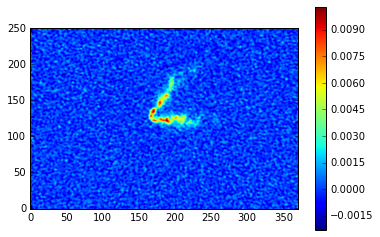

In [8]:
z = 35
im = d[z,:,:]                              #   im = d[z]     also works
plt.imshow(im,origin=['Lower'])
plt.colorbar()

There are 89 channels (slices) in this cube, numbered 0 through 88 in the usual python sense. Pick a few other slices by changing the value in 
**z=** and notice that the first few and last few appear to be just noise and that the V-shaped signal changes shape through the channels. Perhaps you should not be surprised that these are referred to as butterfly diagrams.

(8287769,)


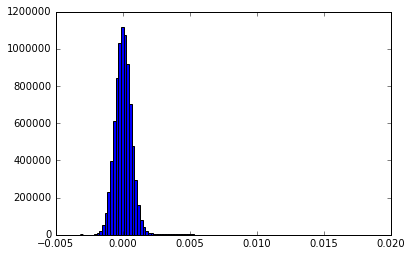

In [9]:
# look at a histogram of all the data (histogram needs a 1D array)
d1 = d.ravel()                 # ravel() doesn't make a new copy of the array, saving memory
print(d1.shape)
(n,b,p) = plt.hist(d1, bins=100)

Notice that the histogram is on the left in the plot, and we already saw the maximum data point is 0.0169835.

So let us plot the vertical axis logarithmically, so we can better see what is going on.

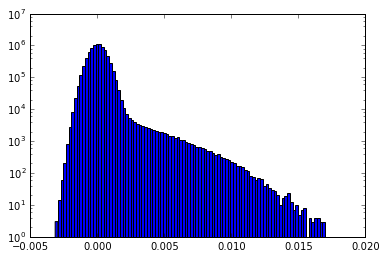

In [10]:
(n,b,p) = plt.hist(d1,bins=100,log=True)

-1.2134e-06 0.000558292


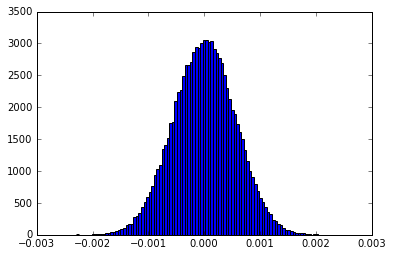

In [11]:
# pick a slice and make a histogram and print the mean and standard deviation of the signal in that slice
z=0
imz = d[z,:,:].flatten()
(n,b,p) = plt.hist(imz,bins=100)
print(imz.mean(), imz.std())


**Exercise** : observe by picking some values of **z** that the noise seems to vary a little bit from one end of the band to the other.  Store the noise in channel 0 and 88 in variables sigma0 and sigma88:


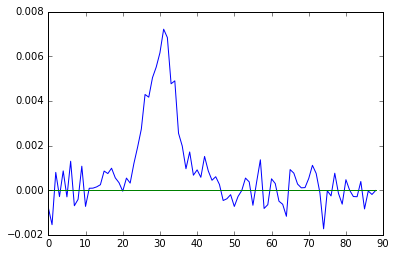

In [12]:
xpeak = 175
ypeak = 125
channel = np.arange(d.shape[0])
spectrum = d[:,ypeak,xpeak]
zero = spectrum * 0.0
plt.plot(channel,spectrum)
plt.plot(channel,zero)

In [13]:
sigma0 = 0.00056
sigma88 = 0.00059

In [14]:
import scipy.signal
import scipy.ndimage.filters as filters

## Smoothing a cube to enhance the signal to noise

(251, 371) -1.2134e-06 0.000186325


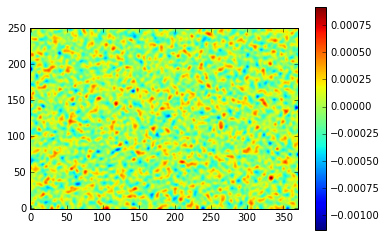

In [15]:
z = 0
sigma = 2.0
ds1 = filters.gaussian_filter(d[z],sigma)                    # ds1 is a single smoothed slice
print(ds1.shape, ds1.mean(), ds1.std())
plt.imshow(ds1,origin=['Lower'])
plt.colorbar()

Notice that the noise is indeed lower than your earlier value of sigma0.   We only smoothed one single slice, but we actually need to smooth the whole cube.  Each slice  with sigma, but we can optionally also smooth in the spectral dimension a little bit. 

0.010926 58.6394


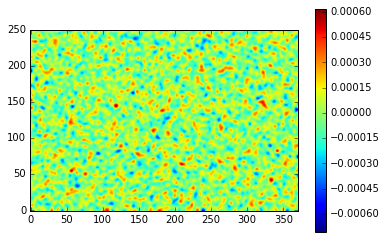

In [16]:
ds = filters.gaussian_filter(d,[1.0,sigma,sigma])              # ds is a smoothed cube
plt.imshow(ds[z],origin=['Lower'])
plt.colorbar()
print(ds.max(),ds.max()/ds1.std())

Notice that, although the peak value was lowered a bit due to the smoothing, the signal to noise has increased from the original cube. So, the signal should stand out a lot better.

**Exercise** : Observe a subtle difference in the last two plots. Can you see what happened here?

## Masking


In [17]:
import numpy.ma as ma

In [18]:
#  sigma0 is the noise in the original cube
nsigma = 0.0
dm = ma.masked_inside(d,-nsigma*sigma0,nsigma*sigma0)
print(dm.count())

8287769


PEAK at location: 149 113 42072


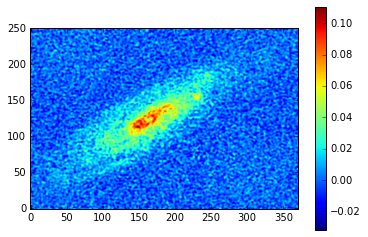

In [19]:
mom0 = dm.sum(axis=0)
plt.imshow(mom0,origin=['Lower'])
plt.colorbar()
#
(ypeak,xpeak) = np.unravel_index(mom0.argmax(),mom0.shape)
print("PEAK at location:",xpeak,ypeak,mom0.argmax())

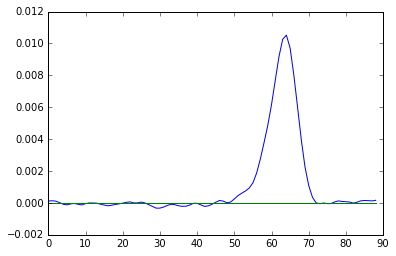

In [20]:
spectrum2 = ds[:,ypeak,xpeak]
plt.plot(channel,spectrum2)
plt.plot(channel,zero)

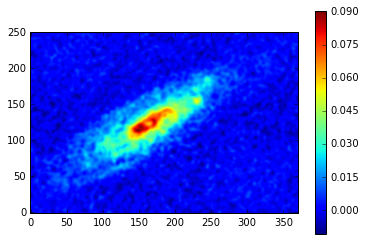

In [21]:
mom0s = ds.sum(axis=0)
plt.imshow(mom0s,origin=['Lower'])
plt.colorbar()

## Velocity fields

The mean velocity is defined as the first moment

$$
<V> = {\Sigma{(v.I)} \over \Sigma{(I)} }
$$

MINMAX -925832.096555 302361.32862


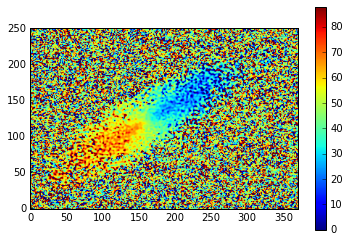

In [22]:
nz = d.shape[0]
vchan = np.arange(nz).reshape(nz,1,1)
vsum = vchan * d
vmean = vsum.sum(axis=0)/d.sum(axis=0)
print("MINMAX",vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=88)
plt.colorbar()

Although we can recognize an area of coherent motions (the red and blue shifted sides of the galaxy), there is a lot of noise in this image. Looking at the math, we are dividing two numbers, both of which can be noise, so the outcome can be "anything".  If anything, it should be a value between 0 and 88, so we could mask for that and see how that looks.

Let us first try to see how the smoothed cube looked.

(251, 371) -379739.299007 1023678.63765


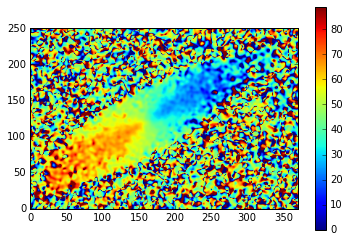

In [23]:
nz = ds.shape[0]
vchan = np.arange(nz).reshape(nz,1,1)
vsum = vchan * ds
vmean = vsum.sum(axis=0)/ds.sum(axis=0)
print(vmean.shape,vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=89)
plt.colorbar()

Although more coherent, there are still bogus values outside the image of the galaxy. So we are looking for a hybrid of the two methods.  In the smooth cube we saw the signal to noise is a lot better defined, so we will define areas in the cube where the signal to noise is high enough and use those in the original high resolution cube.

2.96841e-07 0.000105553


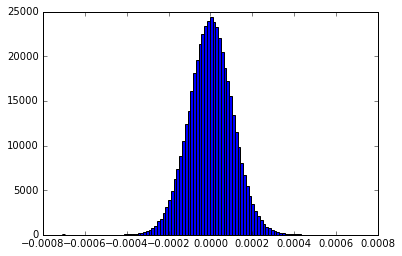

In [24]:
# this is all messy , we need a better solution, a hybrid of the two:
noise = ds[0:5].flatten()
(n,b,p) = plt.hist(noise,bins=100)
print(noise.mean(), noise.std())

In [25]:
sigma0 = noise.std()
nsigma = 5.0
cutoff = sigma0*nsigma
dm = ma.masked_inside(ds,-cutoff,cutoff)
print(cutoff,dm.count())

0.000527763331775 186888


In [26]:
dm2=ma.masked_where(ma.getmask(dm),d)

-9.47214823274 91.7744508962


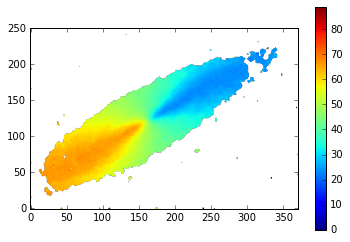

In [27]:
vsum = vchan * dm2
vmean = vsum.sum(axis=0)/dm2.sum(axis=0)
print(vmean.min(),vmean.max())
plt.imshow(vmean,origin=['Lower'],vmin=0,vmax=89)
plt.colorbar()

And voila, now this looks a lot better.

# Epilogue

Some of the pure python constructs that we discussed here, notably masking and smoothing, become cumbersome. In the advanced case we will use some community developed code that makes working with such spectral line image cubes a lot easier.


# Some ipython widget experiments

ipython widgets are interactive widgets that you can add to your script and with a helper function dynamically control output, e.g. a figure.

In [28]:
import networkx as nx
from ipywidgets import interact
